In [1]:
pip install gemini_python

Note: you may need to restart the kernel to use updated packages.


In [2]:
# After pip install, please restart kernel

import json, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Part 1: BTC/USD Report
### Step 1.a. Import Hourly Data

In [3]:
base_url = "https://api.gemini.com/v2"
response_1h = requests.get(base_url + "/candles/btcusd/1hr")
df_btc_1h = pd.DataFrame(response_1h.json(), columns =['time','open','high','low','close','volume'])
df_btc_1h.to_csv('Part1_Input1_df_btc_1h.csv') # Save raw input data

# According to https://docs.gemini.com/rest-api/#candles, the "time" column is in milliseconds
# The following code is to convert "time" into timestamp
df_btc_1h['time'] = pd.to_datetime(df_btc_1h['time'], unit='ms')

# Sorting value by ascending order 
df_btc_1h.sort_values(by =['time'], inplace = True)

# Adding date column
df_btc_1h['date'] = df_btc_1h['time'].dt.normalize()

# Adding hour column, which later will become our x-axis in the chart
df_btc_1h['hour'] = df_btc_1h['time'].dt.hour

# Check the top 5 rows
df_btc_1h.head()

,time,open,high,low,close,volume,date,hour
1460,2021-11-30 08:00:00,56536.35,57414.98,56292.81,56850.02,33.687223,2021-11-30,8
1459,2021-11-30 09:00:00,56850.02,56969.36,56373.36,56778.08,44.225225,2021-11-30,9
1458,2021-11-30 10:00:00,56778.08,57280.38,56637.05,57186.57,21.971379,2021-11-30,10
1457,2021-11-30 11:00:00,57186.57,57744.79,56975.26,57698.29,23.321247,2021-11-30,11
1456,2021-11-30 12:00:00,57698.29,58341.54,57667.52,57872.30,33.591329,2021-11-30,12


### Step 1.b. Import 15-minutes Data for VWAP and Notional Value

In [4]:
# Repeating Step 1.a. for 15 minutes data
# One potential improvement could be packaging this step into class

response_15m = requests.get(base_url + "/candles/btcusd/15m")
df_btc_15m = pd.DataFrame(response_15m.json(), columns =['time','open','high','low','close','volume'])
df_btc_15m.to_csv('Part1_Input2_df_btc_15m.csv') # Save raw input data

# The following code is to convert "time" into timestamp
df_btc_15m['time'] = pd.to_datetime(df_btc_15m['time'], unit='ms')

# Sorting value by ascending order 
df_btc_15m.sort_values(by =['time'], inplace = True)

# Adding date column
df_btc_15m['date'] = df_btc_15m['time'].dt.normalize()

# Adding hour column, which later will become our x-axis in the chart
df_btc_15m['hour'] = df_btc_15m['time'].dt.hour

# Check the top 5 rows
df_btc_15m.head()

,time,open,high,low,close,volume,date,hour
1344,2022-01-16 04:30:00,43037.51,43101.03,43031.69,43073.59,4.759868,2022-01-16,4
1343,2022-01-16 04:45:00,43073.59,43105.42,43042.13,43067.75,6.538190,2022-01-16,4
1342,2022-01-16 05:00:00,43067.75,43130.11,43057.34,43118.46,4.789754,2022-01-16,5
1341,2022-01-16 05:15:00,43118.46,43160.84,43093.61,43129.07,7.018313,2022-01-16,5
1340,2022-01-16 05:30:00,43129.07,43141.72,43087.02,43107.52,4.838558,2022-01-16,5


### Step 1.c. Check Durations of 1 hour dataframe and 15 mins dateframe

In [5]:
# Check the durations of dataframes
print('The earliest timestamp of  hourly dataframe is: ' + str(df_btc_1h['time'].min()))
print('The latest   timestamp of  hourly dataframe is: ' + str(df_btc_1h['time'].max()))
print('The earliest timestamp of 15-mins dataframe is: ' + str(df_btc_15m['time'].min()))
print('The latest   timestamp of 15-mins dataframe is: ' + str(df_btc_15m['time'].max()))

The earliest timestamp of  hourly dataframe is: 2021-11-30 08:00:00
The latest   timestamp of  hourly dataframe is: 2022-01-30 04:00:00
The earliest timestamp of 15-mins dataframe is: 2022-01-16 04:30:00
The latest   timestamp of 15-mins dataframe is: 2022-01-30 04:30:00


### Step 2. Calculate Hourly VWAP Based on 15-minutes Data and Hourly Notional Value

In [6]:
# Setting the date we select based on the data availability (output of Step 1.c.)
date_select = '2022-01-28'
print('Here is the date selected: ' + date_select)

df_1day_btc_1h  = df_btc_1h[df_btc_1h['date'] == date_select].copy()
df_1day_btc_15m = df_btc_15m[df_btc_15m['date'] == date_select].copy()

Here is the date selected: 2022-01-28


In [7]:
############################################################
##################### VWAP Calculation #####################
# 1. Calculate the Typical Price for the period: [(High + Low + Close)/3)]
df_1day_btc_15m['typical_price'] = (df_1day_btc_15m['high'] + df_1day_btc_15m['low'] + df_1day_btc_15m['close'])/3

# 2. Multiply the Typical Price by the period Volume: (Typical Price x Volume)
df_1day_btc_15m['typical_price_times_volume'] = df_1day_btc_15m['typical_price'] * df_1day_btc_15m['volume'] 

# 3.a. Create a Cumulative Total of Typical Price: Cumulative(Typical Price x Volume)
# 3.b. Create a Cumulative Total of Volume: Cumulative(Volume)
agg_func_math = {'typical_price_times_volume':'sum','volume':'sum'}
df_VWAP = df_1day_btc_15m.groupby(['hour']).agg(agg_func_math) # hour become the index of df_VWAP

# 4. Divide the Cumulative Totals: 
# VWAP = Cumulative(Typical Price x Volume) / Cumulative(Volume)
df_VWAP['VWAP'] = round(df_VWAP['typical_price_times_volume']/df_VWAP['volume'],2) #round to 2 decimal places
##################### VWAP Calculation #####################
############################################################


############################################################
################ Notional Value Calculation ################
# Calculate notional value at hour end 
df_1day_btc_1h['notional_value'] = df_1day_btc_1h['close'] * df_1day_btc_1h['volume'] 
################ Notional Value Calculation ################
############################################################


# append hourly VWAP to hourly btc data
df_btc_1h_final = df_1day_btc_1h.set_index(['hour']).join(df_VWAP.drop(columns=['volume','typical_price_times_volume']))
df_btc_1h_final.to_csv('Part1_Output1_df_btc_1h_final.csv') # Save output data
df_btc_1h_final

,time,open,high,low,close,volume,date,notional_value,VWAP
hour,,,,,,,,,
0,2022-01-28 00:00:00,37209.82,37465.62,37105.20,37205.98,54.952939,2022-01-28,2.044578e+06,37275.23
1,2022-01-28 01:00:00,37205.98,37227.51,36754.48,36920.65,36.433006,2022-01-28,1.345130e+06,36983.73
2,2022-01-28 02:00:00,36920.65,36991.55,36656.59,36959.71,30.001715,2022-01-28,1.108855e+06,36816.00
3,2022-01-28 03:00:00,36959.71,37454.62,36933.86,37371.18,41.174769,2022-01-28,1.538750e+06,37315.09
4,2022-01-28 04:00:00,37371.18,37460.93,37027.14,37256.57,47.966442,2022-01-28,1.787065e+06,37313.65
5,2022-01-28 05:00:00,37256.57,37343.38,37134.63,37247.04,17.473682,2022-01-28,6.508429e+05,37237.16
6,2022-01-28 06:00:00,37247.04,37500.00,36948.29,36948.29,55.359258,2022-01-28,2.045430e+06,37254.22
7,2022-01-28 07:00:00,36948.29,37112.61,36791.36,36801.64,18.267403,2022-01-28,6.722704e+05,36935.21
8,2022-01-28 08:00:00,36801.64,36881.09,36452.58,36666.17,41.677881,2022-01-28,1.528168e+06,36624.74


### Step 3. Plot OHLC Prices, VWAP, Volume, and Notional Value

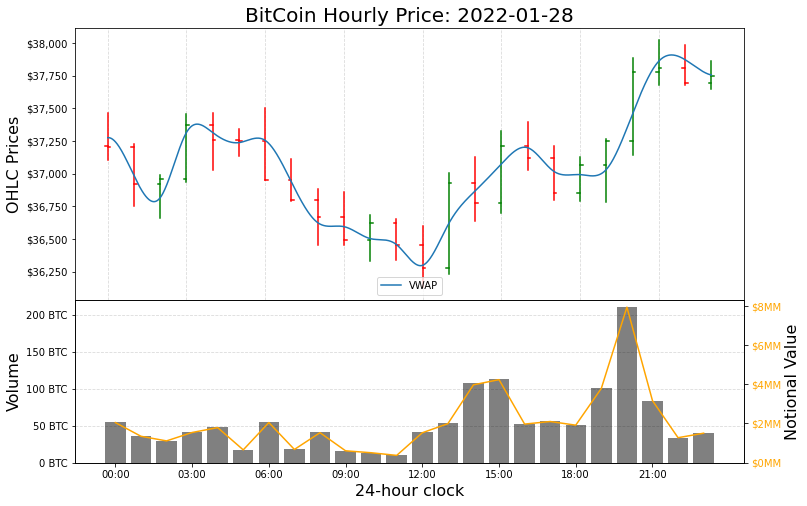

In [8]:
# Using dataframe index "hour" as shared X-Axis
x = df_btc_1h_final.index

# Creating two subplots
fig, (ax0, ax1) = plt.subplots(2, figsize=(12,8), gridspec_kw={'height_ratios': [5, 3]})


############################################################
##################### Data in Subplot 1 ####################
# OHLC Prices in Subplot 1
for idx, val in df_btc_1h_final.iterrows():
    if val['open'] > val['close']: 
        color = 'r' 
    else: 
        color = 'g' 
    #plot high and low price
    ax0.plot([idx, idx], [val['low'], val['high']], color=color)
    #plot open price to the left 
    ax0.plot([idx, idx-0.1], [val['open'], val['open']], color=color)
    #plot close price to the right 
    ax0.plot([idx, idx+0.1], [val['close'], val['close']], color=color)

# Adding VWAP curve to the OHLC Prices Chart in Subplot 1 
from scipy.interpolate import make_interp_spline
xnew = np.linspace(x.min(), x.max(), 2400) # 2400 represents number of points to smoothen VWAP plot
vwap = df_btc_1h_final['VWAP']
spl = make_interp_spline(x, vwap)          # Default is cubic, k=3; cubic spline to smoothen VWAP plot
power_smooth = spl(xnew)
ax0.plot(xnew, power_smooth, label = 'VWAP')
ax0.legend(loc='lower center')
##################### Data in Subplot 1 ####################
############################################################


############################################################
##################### Data in Subplot 2 ####################
# Volume in Subplot 2
ax1.bar(x, df_btc_1h_final['volume'], color='grey')

# Notional Value also in Subplot 2
ax2 = ax1.twinx()                  # instantiate a secondary Y-axis that shares the same X-axis with ax1 (i.e., Subplot 2)
ax2.plot(x, df_btc_1h_final['notional_value'], color='orange')
##################### Data in Subplot 2 ####################
############################################################


############################################################
################ Adding more plot aesthetics ###############
# Adding Labels
ax0.set_ylabel('OHLC Prices', fontsize=16)
ax1.set_ylabel('Volume', fontsize=16)
ax2.set_ylabel('Notional Value', fontsize=16) 
ax1.set_xlabel('24-hour clock', fontsize=16)
ax2.tick_params(axis='y', labelcolor='orange')

# Adding Grid
ax0.xaxis.grid(color='black', linestyle='dashed', which='major', alpha=0.15) 
ax1.yaxis.grid(color='black', linestyle='dashed', which='major', alpha=0.15) 

# Adding X Ticks
ax0.set_xticks(x[::3])
ax1.set_xticks(x[::3])
ax1.set_xticklabels(df_btc_1h_final['time'].dt.strftime('%H:%M')[::3]) # setting ticks for every 3 hours

# Adding Y Ticks
ax0.yaxis.set_major_formatter('${x:,.0f}')                            # Adding "$" sign, thousand seperator,
ax1.yaxis.set_major_formatter('{x:.0f} BTC')  

from matplotlib.ticker import FuncFormatter
ax2_yticks = FuncFormatter(lambda x, pos: '${:,.0f}MM'.format(x/1e6)) # Adding "$" sign, thousand seperator, scaling to MM
ax2.yaxis.set_major_formatter(ax2_yticks)

# Adding Title
ax0.set_title('BitCoin Hourly Price: ' + date_select ,  fontsize=20)
# no spacing between the subplots
plt.subplots_adjust(hspace=0)
plt.show()
################ Adding more plot aesthetics ###############
############################################################


# Part 2: ETH/BTC Report
### Step 1. Data Preparation

In [9]:
base_url = "https://api.gemini.com/v2"

# ETH/BTC trading data
response_ethbtc = requests.get(base_url + "/candles/ethbtc/1hr")
df_ethbtc_full = pd.DataFrame(response_ethbtc.json(), columns =['time','open','high','low','close','volume'])
df_ethbtc_full.to_csv('Part2_Input1_df_ethbtc_full.csv') # Save raw input data 

# BTC/USD trading data
response_btcusd = requests.get(base_url + "/candles/btcusd/1hr")
df_btcusd_full = pd.DataFrame(response_btcusd.json(), columns =['time','open','high','low','close','volume'])
df_btcusd_full.to_csv('Part2_Input2_df_btcusd_full.csv') # Save raw input data, should be identical as df_btc_1h before any data manipulation

def DataPreparation(df_temp):    
    # According to https://docs.gemini.com/rest-api/#candles, the "time" column is in milliseconds
    # The following code is to convert "time" into timestamp
    df_temp['time'] = pd.to_datetime(df_temp['time'], unit='ms')
    # Adding 'date' and 'hour' columns
    df_temp['date'] = df_temp['time'].dt.normalize()
    df_temp['hour'] = df_temp['time'].dt.hour
    # Sorting values by "time" and set index as "time"
    df_temp.sort_values(by =['time'], inplace = True)
    df_temp.set_index(['time'], inplace = True)
    return df_temp

df_ethbtc_full = DataPreparation(df_ethbtc_full)
df_btcusd_full = DataPreparation(df_btcusd_full)

# Inner joining ETH/BTC and BTC/USD trading data to get ETH/USD price
df_ethbtc = df_ethbtc_full.join(
    df_btcusd_full[['close']], 
    how = 'inner',  
    rsuffix='_btcusd'
    )

# Add ETH/USD close price and ETH Notional Value in USD
df_ethbtc['close_ethusd'] = df_ethbtc['close'] * df_ethbtc['close_btcusd']           # Convert to ETH/USD
df_ethbtc['notional_value_in_usd'] = df_ethbtc['volume'] * df_ethbtc['close_ethusd']  

# Check the top 5 rows
df_ethbtc.head()

,open,high,low,close,volume,date,hour,close_btcusd,close_ethusd,notional_value_in_usd
time,,,,,,,,,,
2021-11-30 08:00:00,0.07781,0.07818,0.07781,0.07802,7.731182,2021-11-30,8,56850.02,4435.438560,34291.181873
2021-11-30 09:00:00,0.07802,0.07832,0.07795,0.07831,17.231486,2021-11-30,9,56778.08,4446.291445,76616.209806
2021-11-30 10:00:00,0.07831,0.07853,0.07821,0.07853,29.972272,2021-11-30,10,57186.57,4490.861342,134601.319007
2021-11-30 11:00:00,0.07853,0.07977,0.07837,0.07977,88.584496,2021-11-30,11,57698.29,4602.592593,407718.345723
2021-11-30 12:00:00,0.07977,0.07988,0.07900,0.07919,126.172858,2021-11-30,12,57872.30,4582.907437,578238.531292


### Step 2. Select Date and Prepare for 7-day Average Plot (Additional Enhancement)

In [10]:
# Check the durations of dataframes
print('The earliest timestamp of hourly ETH/USD dataframe is: ' + str(df_ethbtc.index.min()))
print('The latest   timestamp of hourly ETH/USD dataframe is: ' + str(df_ethbtc.index.max()))

The earliest timestamp of hourly ETH/USD dataframe is: 2021-11-30 08:00:00
The latest   timestamp of hourly ETH/USD dataframe is: 2022-01-30 04:00:00


In [11]:
# Setting the date we select based on the data availability 
date_select = '2022-01-28' 

# 1-day of data based on date_select
df_1day_eth  = df_ethbtc[df_ethbtc['date'] == date_select].copy()
df_1day_eth.to_csv('Part2_Output1_df_1day_eth.csv')  # Save output data 
print('Here is the date selected: ' + date_select)

# Checking if last 7-day data is available
dt_upper = pd.to_datetime(date_select) + pd.DateOffset(hours=-1)
dt_lower = pd.to_datetime(date_select) + pd.DateOffset(days=-7)

if df_ethbtc.index.min() <= dt_lower and df_ethbtc.index.max() >= dt_upper:
    option_code_7day = 1
    print('Last 7-day average plot is supported by the data availability')
    df_7day_eth = df_ethbtc[(df_ethbtc.index <= dt_upper) & (df_ethbtc.index >= dt_lower)]
    df_7day_mean_eth = df_7day_eth.groupby(['hour']).agg({'notional_value_in_usd':'mean'})
    df_7day_mean_eth.to_csv('Part2_Output2_df_7day_mean_eth.csv')  # Save output data 
else:
    option_code_7day = 0
    print('Last 7-day average plot is NOT supported by the data availability')
    
#df_7day_ethusd

Here is the date selected: 2022-01-28
Last 7-day average plot is supported by the data availability


### Step 3. Plot OHLC Prices in BTC and Notional Value in USD

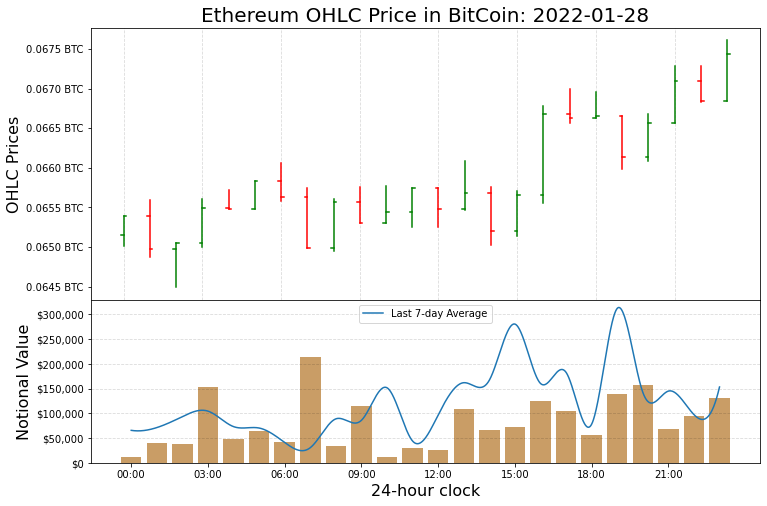

In [12]:
fig, (ax0,ax1) = plt.subplots(2, figsize=(12,8), gridspec_kw={'height_ratios': [5, 3]})

# OHLC Prices in Subplot 1
for idx, val in df_1day_eth.reset_index().iterrows():
    if val['open'] > val['close']: 
        color = 'r' 
    else: 
        color = 'g' 
    #plot high and low price
    ax0.plot([idx, idx], [val['low'], val['high']], color=color)
    #plot open price to the left 
    ax0.plot([idx, idx-0.1], [val['open'], val['open']], color=color)
    #plot close price to the right 
    ax0.plot([idx, idx+0.1], [val['close'], val['close']], color=color)


color = '#c99d66' # Ethereum Gold Hex Number: https://www.designpieces.com/palette/ethereum-colour-palette-hex-and-rgb/
ax1.bar(df_1day_eth['hour'], df_1day_eth['notional_value_in_usd'], color=color) # Bar Chart

# Set X-Axis
ax0.set_xticks(df_1day_eth['hour'][::3]) 
ax1.set_xticks(df_1day_eth['hour'][::3])                      
ax1.set_xticklabels(df_1day_eth.index.strftime('%H:%M')[::3])  
ax1.set_xlabel('24-hour clock', fontsize=16)

# Set Y-Axis
ax0.yaxis.set_major_formatter('{x:,.4f} BTC')
ax0.set_ylabel('OHLC Prices', fontsize=16)
ax1.yaxis.set_major_formatter('${x:,.0f}') 
ax1.set_ylabel('Notional Value', fontsize=16)

# Adding Title
ax0.set_title('Ethereum OHLC Price in BitCoin: ' + date_select ,  fontsize=20)

# Adding Grid
ax0.xaxis.grid(color='black', linestyle='dashed', which='major', alpha=0.15) # Top Chart - X Axis - Only Major Ticks
ax1.yaxis.grid(color='black', linestyle='dashed', which='both', alpha=0.15)  # Bottom Chart - Y Axis - Both

# If the last 7-day data is available, a blue line of 7-day average plot will show in the bottom chart
if option_code_7day == 1:
    # Apply the same technic to smooth the 7-day average
    x = df_7day_mean_eth.index
    xnew = np.linspace(x.min(), x.max(), 2400) 
    spl = make_interp_spline(x, df_7day_mean_eth['notional_value_in_usd'])      
    power_smooth = spl(xnew)
    ax1.plot(xnew, power_smooth, label = 'Last 7-day Average')
    ax1.legend(loc='upper center')

plt.subplots_adjust(hspace=0) 
plt.show()

### Part 1 - BTC/USD Report
#### Input Data: df_btc_1h.csv, df_btc_15m.csv (to calcualte VWAP)
#### Output Data: df_btc_1h_final.csv


### Part 2 - ETH/BTC Report
#### Input Data: df_ethbtc_full.csv, df_btcusd_full.csv (identical to df_btc_1h.csv)
#### Output Data: df_1day_eth.csv, df_7day_mean_eth.csv (depend on date selected, if last 7 days of data exists)

# Appendix: Referenece Code
###  1. Ploting discrete values and smoothen the curve 

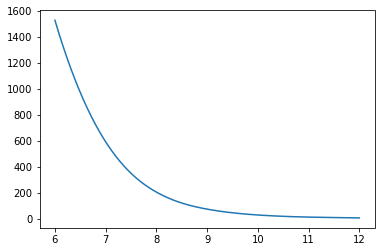

In [13]:
# https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline, BSpline

T = np.array([6, 7, 8, 9, 10, 11, 12])
power = np.array([1.53E+03, 5.92E+02, 2.04E+02, 7.24E+01, 2.72E+01, 1.10E+01, 4.70E+00])

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(T.min(), T.max(), 300) 

spl = make_interp_spline(T, power, k=3)  # type: BSpline
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)
plt.show()

### 2.Adding a secondary Y-Axis in a chart

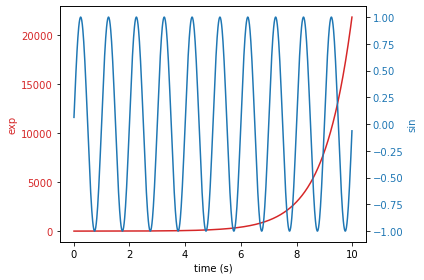

In [14]:
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/two_scales.html
    
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()